# Collaborative Filtering Recommender Systems

This notebook is prepared by the notes from Unsupervised Learning, Recommenders, Reinforcement Learning by DeepLearning.AI Coursera. I would like to thank Andrew NG for this great lecture. The notations and  vectrized cost function are directly copied from the lecture. I prepared the data from scratch, get input data, made the code modular (app.py, train_predict_page.py and utils.py). I've also train the model with different hyperparameters. Also, you can run the project on a dashboard which prepared by streamlit:)


The data set is derived from the [MovieLens "ml-latest-small"](https://grouplens.org/datasets/movielens/latest/) dataset.   
[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

## Making recommendations

Recommend items to you based on:
    
    Ratings of users who gave similar ratings as you. 
    
Predict rating of user j on movie i:  w_j * x_i +b_j

In [1]:
from platform import python_version
print(python_version())

3.10.0


In [2]:
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from recsys_utils import *

## Load Datasets

Let's load the datasets and make EDA. 

In [3]:
df_movie = pd.read_csv('./data/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
df_tags = pd.read_csv('./data/ml-latest-small/tags.csv')
df_links = pd.read_csv('./data/ml-latest-small/links.csv')

In [4]:
print(df_movie.shape)
print(df_ratings.shape)

(9742, 3)
(100836, 4)


In [5]:
print(len(list(df_movie.movieId.unique())))
print(len(list(df_ratings.movieId.unique())))

9742
9724


In [6]:
print(len(list(df_movie.title.unique())))

9737


In [7]:
df_ratings['datetime'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

## Average Ratings for each Movie

Calculate the average ratings & number of ratings for each movie. 

In [8]:
df_temp = df_ratings.groupby('movieId').agg({'movieId': 'count', 'rating':'mean'})
df_temp.rename(columns={'movieId':'number_of_ratings', 'rating': 'mean_rating'}, inplace=True)
df_ratings_mean = df_temp.reset_index()

df_ratings_mean = pd.merge(df_ratings_mean, df_movie, on='movieId', how='left')
df_ratings_mean.shape

(9724, 5)

In [9]:
# flag the last duplicated movie based on title
df_ratings_mean['Last_dup1'] = np.where(df_ratings_mean['title'].duplicated(keep='last'), 0, 1)

In [10]:
# movieIds of the last duplicated movies
duplicated_movies_list = list(df_ratings_mean[df_ratings_mean.Last_dup1 == 0]["movieId"])

In [11]:
# remove last duplicated movies based on title
df_ratings_mean = df_ratings_mean.drop_duplicates(subset=["title"], keep="first")

In [12]:
# remove duplicated movies based on movieIds
df_ratings = df_ratings[~df_ratings.movieId.isin(duplicated_movies_list)]

In [13]:
df_ratings_mean['movie_id_2'] = df_ratings_mean.index

Movie Id and Index are not mathced. We need to keep the index number for further selection. 

In [14]:
print(len(list(set(df_ratings_mean.title))))
print(len(list(set(df_ratings_mean.movieId))))
print(len(list(set(df_ratings_mean.movie_id_2))))

9719
9719
9719


In [15]:
print(len(list(set(df_ratings.movieId))))

9719


In [16]:
print(len(list(set(df_movie.title))))
print(len(list(set(df_movie.movieId))))

9737
9742


In [20]:
xx = df_ratings_mean.sort_values(by="mean_rating", ascending=False)
all_genres_df_temp_index_1 = list(xx["movie_id_2"])
all_genres_df_temp_index_1

[8699,
 9104,
 4240,
 666,
 6034,
 9065,
 9076,
 4200,
 9078,
 4172,
 6084,
 9111,
 9126,
 4103,
 9113,
 6166,
 4102,
 9119,
 9120,
 9122,
 9123,
 9124,
 4245,
 9050,
 9039,
 9037,
 8964,
 8967,
 8968,
 4468,
 8975,
 8097,
 8989,
 8994,
 5890,
 8089,
 9004,
 4384,
 4369,
 4366,
 9024,
 1888,
 9028,
 5926,
 8056,
 9125,
 6172,
 9347,
 9263,
 6482,
 6494,
 9216,
 7927,
 3802,
 9237,
 3754,
 3753,
 1227,
 9266,
 7975,
 9271,
 9281,
 7899,
 9299,
 7890,
 9319,
 7885,
 6745,
 7868,
 3847,
 6478,
 3888,
 9196,
 6194,
 9134,
 8498,
 7972,
 4039,
 4038,
 6266,
 7960,
 4032,
 7948,
 3969,
 3931,
 9162,
 9167,
 9168,
 6393,
 9176,
 3918,
 3903,
 5862,
 8130,
 8136,
 8689,
 1539,
 5453,
 8656,
 8657,
 5480,
 8365,
 5484,
 5490,
 8363,
 8691,
 8943,
 8348,
 8337,
 8708,
 5519,
 5015,
 8325,
 8320,
 8316,
 433,
 5447,
 8628,
 8627,
 1646,
 5334,
 8533,
 5297,
 5414,
 5417,
 5423,
 5277,
 8486,
 5226,
 5436,
 8573,
 5437,
 531,
 8592,
 8605,
 536,
 8609,
 5128,
 8446,
 432,
 8734,
 5572,
 8232,
 885

In [21]:
df_ratings_mean.reindex(all_genres_df_temp_index_1)

,movieId,number_of_ratings,mean_rating,title,genres,Last_dup1,movie_id_2
8699,126088,1,5.0,A Flintstones Christmas Carol (1994),Animation|Children|Comedy,1,8699
9104,145994,1,5.0,Formula of Love (1984),Comedy,1,9104
4240,6192,1,5.0,Open Hearts (Elsker dig for evigt) (2002),Romance,1,4240
666,876,1,5.0,Supercop 2 (Project S) (Chao ji ji hua) (1993),Action|Comedy|Crime|Thriller,1,666
6034,40491,1,5.0,"Match Factory Girl, The (Tulitikkutehtaan tytt...",Comedy|Drama,1,6034
...,...,...,...,...,...,...,...
3816,5356,1,0.5,"Giant Spider Invasion, The (1975)",Horror|Sci-Fi,1,3816
7560,86068,1,0.5,Films to Keep You Awake: The Christmas Tale (P...,Horror|Thriller,1,7560
6486,53453,1,0.5,Starcrash (a.k.a. Star Crash) (1978),Action|Adventure|Fantasy|Sci-Fi,1,6486
5781,31692,1,0.5,Uncle Nino (2003),Comedy,1,5781


In [22]:
# Get unique genre types from df_movie
genre_types = df_ratings_mean.genres
genre_types_m = genre_types.str.split('|', expand=True)
all_genres = []
for i in range(10):
    all_genres.append(list(genre_types_m[i].unique()))

In [23]:
all_genres

[['Adventure',
  'Comedy',
  'Action',
  'Drama',
  'Crime',
  'Children',
  'Mystery',
  'Animation',
  'Documentary',
  'Thriller',
  'Horror',
  'Fantasy',
  'Western',
  'Film-Noir',
  'Romance',
  'Sci-Fi',
  'Musical',
  'War',
  '(no genres listed)'],
 ['Animation',
  'Children',
  'Romance',
  'Drama',
  None,
  'Crime',
  'Adventure',
  'Horror',
  'Comedy',
  'Sci-Fi',
  'War',
  'Thriller',
  'Mystery',
  'Film-Noir',
  'Fantasy',
  'Musical',
  'Western',
  'IMAX',
  'Documentary'],
 ['Children',
  'Fantasy',
  None,
  'Romance',
  'Thriller',
  'Crime',
  'Horror',
  'Drama',
  'Comedy',
  'War',
  'IMAX',
  'Mystery',
  'Western',
  'Sci-Fi',
  'Animation',
  'Musical',
  'Film-Noir',
  'Documentary'],
 ['Comedy',
  None,
  'Drama',
  'Mystery',
  'Musical',
  'Thriller',
  'Romance',
  'Crime',
  'War',
  'Sci-Fi',
  'Fantasy',
  'Western',
  'Children',
  'Horror',
  'Film-Noir',
  'IMAX',
  'Documentary'],
 ['Fantasy',
  None,
  'Thriller',
  'Sci-Fi',
  'Romance',
  '

In [24]:
# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
list_genre = [item for sublist in all_genres for item in sublist]
list_genre = list(set(list_genre))
list_genre.remove("(no genres listed)")
list_genre.remove(None)
list_genre

['Animation',
 'Romance',
 'Documentary',
 'War',
 'Action',
 'Crime',
 'Fantasy',
 'Mystery',
 'Children',
 'Drama',
 'Western',
 'Film-Noir',
 'Horror',
 'Thriller',
 'Musical',
 'Comedy',
 'IMAX',
 'Sci-Fi',
 'Adventure']

In [25]:
# Create columns for each genre type (1 - 0 encoded values)
for col in list_genre:
    df_ratings_mean[col] = 0

for col in list_genre:
    df_ratings_mean[col] = np.where(df_ratings_mean['genres'].str.contains(col) == True, 1, 0)

In [26]:
df_ratings_mean

,movieId,number_of_ratings,mean_rating,title,genres,Last_dup1,movie_id_2,Animation,Romance,Documentary,...,Drama,Western,Film-Noir,Horror,Thriller,Musical,Comedy,IMAX,Sci-Fi,Adventure
0,1,215,3.920930,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,110,3.431818,Jumanji (1995),Adventure|Children|Fantasy,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,52,3.259615,Grumpier Old Men (1995),Comedy|Romance,1,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,4,7,2.357143,Waiting to Exhale (1995),Comedy|Drama|Romance,1,3,0,1,0,...,1,0,0,0,0,0,1,0,0,0
4,5,49,3.071429,Father of the Bride Part II (1995),Comedy,1,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,193581,1,4.000000,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1,9719,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9720,193583,1,3.500000,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,1,9720,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9721,193585,1,3.500000,Flint (2017),Drama,1,9721,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9722,193587,1,3.500000,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,1,9722,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
most_rated = df_ratings_mean[df_ratings_mean.number_of_ratings == df_ratings_mean.number_of_ratings.max()]
idx = most_rated.movieId.item()
most_rated_df = df_ratings[df_ratings.movieId == idx]
most_rated_df['year'] = pd.DatetimeIndex(most_rated_df['datetime']).year
agg_df = most_rated_df.groupby('year').agg({'rating': 'mean'})
agg_df = agg_df.reset_index()

C:\Users\pelin\AppData\Local\Temp\ipykernel_24096\4087907364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_rated_df['year'] = pd.DatetimeIndex(most_rated_df['datetime']).year


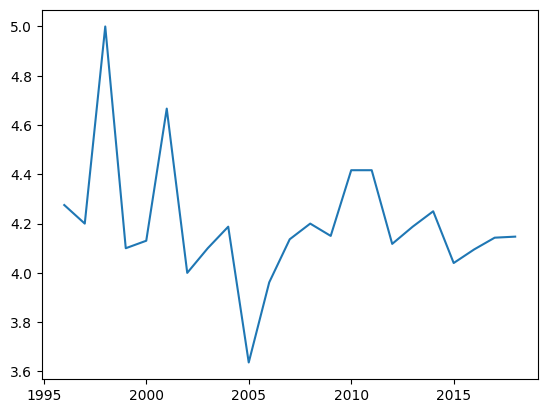

In [67]:
from matplotlib import pyplot as plt
plt.plot(agg_df.year, agg_df.rating)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(agg_df.year, agg_df.rating)
st.write("""#### Number of Data from different countries""")

st.pyplot(fig1)

In [36]:
# Selected movies for all genre types (Most rated 30 movies for each genre)
df_ratings_mean_22 = df_ratings_mean.copy()
all_genres = []
for genre in list_genre:
    genre_temp = df_ratings_mean_22[np.array(df_ratings_mean_22.filter(regex=genre) == 1).reshape
    (len(df_ratings_mean_22), )].sort_values(
        by='number_of_ratings', ascending=False).head(30)
    genre_temp_movie_id = list(genre_temp["movie_id_2"])
    
    df_ratings_mean_22 = df_ratings_mean_22[~df_ratings_mean_22.movie_id_2.isin(genre_temp_movie_id)]
    all_genres.append(genre_temp)
all_genres_df = pd.concat(all_genres)

In [37]:
len(all_genres_df)

570

In [38]:
len(list(all_genres_df.movie_id_2.unique()))

570

In [17]:
temp = pd.merge(df_movie, df_ratings_mean, on='movieId', how='left')
temp.number_of_ratings.isnull().sum()

23

In [18]:
movieList = list(df_ratings_mean.title)
len(movieList)

9719

In [19]:
len(df_ratings_mean)

9719

In [20]:
num_movies = len(list(df_ratings.movieId.unique()))
num_movies

9719

In [21]:
num_movies_control = len(list(df_movie.movieId.unique()))
num_movies_control

9742

In [22]:
# How many users in the data?

num_users = len(list(df_ratings.userId.unique()))
num_users

610

In [23]:
# How many movies in the data?

num_movies = len(list(df_ratings.movieId.unique()))
num_movies

9719

## Genre

In [24]:
genre_types = df_ratings_mean.genres
genre_types_m = genre_types.str.split('|',expand=True)
all_genres = []
for i in range(10):
    all_genres.append(list(genre_types_m[i].unique()))

# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
list_genre = [item for sublist in all_genres for item in sublist]
list_genre = list(set(list_genre))
list_genre.remove("(no genres listed)")
list_genre.remove(None)
list_genre

['Documentary',
 'Romance',
 'Mystery',
 'Thriller',
 'Comedy',
 'Action',
 'Drama',
 'Horror',
 'Fantasy',
 'War',
 'Animation',
 'Film-Noir',
 'Children',
 'Sci-Fi',
 'Musical',
 'IMAX',
 'Crime',
 'Adventure',
 'Western']

In [25]:
for col in list_genre:
    df_ratings_mean[col] = 0
    
for col in list_genre:
    df_ratings_mean[col] = np.where(df_ratings_mean['genres'].str.contains(col) == True, 1, 0)

## Create matrices

𝑟(𝑖,𝑗) 	scalar; = 1 if user j rated movie i = 0 otherwise	
𝑦(𝑖,𝑗) 	scalar; = rating given by user j on movie i (if r(i,j) = 1 is defined)	

In [26]:
y_matrix = df_ratings.pivot(index='movieId', columns='userId', values='rating')
y_matrix =y_matrix.fillna(0)

df_ratings['temp'] = 1
r_matrix = df_ratings.pivot(index='movieId', columns='userId', values='temp')
r_matrix =r_matrix.fillna(0)

In [27]:
y_matrix = y_matrix.reset_index()
y_matrix = y_matrix.drop('movieId', axis=1)

r_matrix = r_matrix.reset_index()
r_matrix = r_matrix.drop('movieId', axis=1)

In [28]:
Y = y_matrix.to_numpy()
R = r_matrix.to_numpy()

In [29]:
Y.shape

(9719, 610)

In [30]:
# Cost function with loop
def cofi_cost_func(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    nm, nu = Y.shape
    J = 0
    for j in range(nu):
        for i in range(nm):
            pred = np.dot(W[j,:], X[i,:]) + b[0,j] 
            squared_error = np.dot(R[i,j], np.square(pred - Y[i,j]))
            J += squared_error
    J /= 2  
    reg_w = lambda_ * np.sum(np.square(W)) * 0.5
    reg_x = lambda_ *np.sum(np.square(X)) * 0.5
    
    J = J + reg_w + reg_x
    return J

In [31]:
# Vectorized cost function
# *by DeepLearning.AI*
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

## Input From User

Now it is time to add some personal data the dataset. I am aware that it doesn't well designed, but it was a fun to write:)

In [32]:
df_ratings_mean_temp = df_ratings_mean.copy()
my_ratings = np.zeros(num_movies) 

selected_movies = df_ratings_mean_temp[df_ratings_mean_temp['genres'].str.contains("Comedy")].sort_values(
        by='number_of_ratings', ascending=False)
selected_movies = selected_movies.head(30)
# selected_movies = selected_movies.sample(frac=1)
selected_movies.head()

,movieId,number_of_ratings,mean_rating,title,genres,Last_dup1,movie_id_2,Documentary,Romance,Mystery,...,War,Animation,Film-Noir,Children,Sci-Fi,Musical,IMAX,Crime,Adventure,Western
314,356,329,4.164134,Forrest Gump (1994),Comedy|Drama|Romance|War,1,314,0,1,0,...,1,0,0,0,0,0,0,0,0,0
257,296,307,4.197068,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1,257,0,0,0,...,0,0,0,0,0,0,0,1,0,0
0,1,215,3.920930,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
506,588,183,3.792350,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,1,506,0,0,0,...,0,1,0,1,0,1,0,0,1,0
520,608,181,4.116022,Fargo (1996),Comedy|Crime|Drama|Thriller,1,520,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# print('Title: ', selected_movies.title.iloc[0])
# print('Movie_id_2: {}, movieId: {}'.format(selected_movies.movie_id_2.iloc[0], selected_movies.movieId.iloc[0]))

In [ ]:
# rating_i = int(input('Your rating: '))
# current_movie_id = selected_movies.movieId.iloc[0]
# current_movie_id_2 = selected_movies.movie_id_2.iloc[0]
# my_ratings[idx] = rating_i

In [ ]:
# my_ratings[314]

In [ ]:
# print('control')
# print(df_ratings_mean[df_ratings_mean.movie_id_2 == current_movie_id_2]['title'])
# print(movieList[current_movie_id_2])

In [ ]:
# df_ratings_mean_temp = df_ratings_mean_temp[(df_ratings_mean_temp.movieId  != movie_idx)]

In [41]:
def get_ratings_from_user(df_ratings_mean, genre):
    """
    This function select the movies based on the genre. Get top 5 movies and then remove them from the dataset. 
    Since, a movie may has more than one genres.
    
    df_ratings_mean: (df) the rating matrix 
    genre: (str) specific genre
    """
    selected_movies = df_ratings_mean[df_ratings_mean['genres'].str.contains(genre)].sort_values(
        by='number_of_ratings', ascending=False)
    selected_movies = selected_movies.head(30)
    selected_movies = selected_movies.sample(frac=1)
    for i in range(5):
        print('NEW RATING')
        print('Movie:', selected_movies.title.iloc[i])
        print('Movie_id_2: {}, movieId: {}'.format(selected_movies.movie_id_2.iloc[0], selected_movies.movieId.iloc[0]))
        rating_i = int(input('Your rating: '))
        current_movieId = selected_movies.movieId.iloc[i]
        current_movie_id_2 = selected_movies.movie_id_2.iloc[i]
        my_ratings[current_movie_id_2] = rating_i
        
        print('control')
        print(df_ratings_mean[df_ratings_mean.movie_id_2 == current_movie_id_2]['title'])
        print(movieList[current_movie_id_2])
        
        df_ratings_mean = df_ratings_mean[(df_ratings_mean.movieId  != current_movieId)]
    return my_ratings, df_ratings_mean  

In [38]:
print(df_ratings_mean.shape)
df_ratings_mean_temp = df_ratings_mean.copy()

all_genres = []
for genre in list_genre[0]:
    genre_temp = df_ratings_mean_temp[np.array(df_ratings_mean_temp.filter(regex=list_genre[0]) == 1).reshape
                                      (len(df_ratings_mean_temp),)].sort_values(
        by='number_of_ratings', ascending=False).head(2)
    all_genres.append(genre_temp)

all_genres_df = pd.concat(all_genres)

(9719, 26)


In [42]:
# Create a series
my_ratings = np.zeros(num_movies) 

print("Give 0, if you haven't seen the movie yet. Give 1-5 ratings. Let's start!:) ")
comedy_b = input('Love comedies? Y/N: ')
if comedy_b == 'Y':
    my_ratings, df_ratings_mean_temp = get_ratings_from_user(df_ratings_mean_temp, "Comedy")

# print(df_ratings_mean_temp.shape)

# romance_b = input('Love romance? Y/N: ')
# if romance_b == 'Y':
#     my_ratings, df_ratings_mean_temp = get_ratings_from_user(df_ratings_mean_temp, "Romance")

# scific_b = input('Love scifi? Y/N: ')
# if scific_b == 'Y':
#     my_ratings, df_ratings_mean_temp = get_ratings_from_user(df_ratings_mean_temp, "Sci")

# name = input('What is you favourite movie? ')
# fav_mov = df_ratings_mean_temp[df_ratings_mean_temp['title'].str.lower().str.contains(name.lower())].sort_values(
#     by='number_of_ratings', ascending=False)
# print(fav_mov)
# if len(fav_mov)>=1:
#     for i in range(min(4, len(fav_mov))):
#         print('Movie number ', str(i), ': ', fav_mov.title.iloc[i])
#         rating_i = int(input('Your rating: '))
#         print('Movie number index', fav_mov.movie_id_2.iloc[i])
#         movie_idx = fav_mov.movieId.iloc[i]
#         idx = fav_mov.movie_id_2.iloc[i]
#         my_ratings[idx] = rating_i
#         df_ratings_mean_temp = df_ratings_mean_temp.iloc[i: , :]
# else:
#     print('Thank you:) Wait for the recommendation!')

# print('Thank you:) Wait for the recommendation!')

Give 0, if you haven't seen the movie yet. Give 1-5 ratings. Let's start!:) 
Love comedies? Y/N: Y
NEW RATING
Movie: Monty Python and the Holy Grail (1975)
Movie_id_2: 862, movieId: 1136
Your rating: 1
control
862    Monty Python and the Holy Grail (1975)
Name: title, dtype: object
Monty Python and the Holy Grail (1975)
NEW RATING
Movie: Aladdin (1992)
Movie_id_2: 862, movieId: 1136
Your rating: 2
control
506    Aladdin (1992)
Name: title, dtype: object
Aladdin (1992)
NEW RATING
Movie: Groundhog Day (1993)
Movie_id_2: 862, movieId: 1136
Your rating: 3
control
963    Groundhog Day (1993)
Name: title, dtype: object
Groundhog Day (1993)
NEW RATING
Movie: Monsters, Inc. (2001)
Movie_id_2: 862, movieId: 1136
Your rating: 3
control
3563    Monsters, Inc. (2001)
Name: title, dtype: object
Monsters, Inc. (2001)
NEW RATING
Movie: Dumb & Dumber (Dumb and Dumber) (1994)
Movie_id_2: 862, movieId: 1136
Your rating: 5
control
197    Dumb & Dumber (Dumb and Dumber) (1994)
Name: title, dtype: object
D

In [43]:
my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(i)
        print(f'Rated {my_ratings[i]} for  {df_ratings_mean.loc[i,"title"]}');


New user ratings:

197
Rated 5.0 for  Dumb & Dumber (Dumb and Dumber) (1994)
506
Rated 2.0 for  Aladdin (1992)
862
Rated 1.0 for  Monty Python and the Holy Grail (1975)
963
Rated 3.0 for  Groundhog Day (1993)
3563
Rated 3.0 for  Monsters, Inc. (2001)


In [44]:
movieList[197]

'Dumb & Dumber (Dumb and Dumber) (1994)'

In [45]:
df_ratings_mean.loc[197,"title"]

'Dumb & Dumber (Dumb and Dumber) (1994)'

In [47]:
my_ratings[197]

5.0

## Add User Inputs to Dataset 

*by DeepLearning.AI*

In [48]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Only include real ratings R(i,j)=1.
    [Ynorm, Ymean] = normalizeRatings(Y, R) normalized Y so that each movie
    has a rating of 0 on average. Unrated moves then have a mean rating (0)
    Returns the mean rating in Ymean.
    """
    Ymean = (np.sum(Y*R,axis=1)/(np.sum(R, axis=1)+1e-12)).reshape(-1,1)
    Ynorm = Y - np.multiply(Ymean, R) 
    return(Ynorm, Ymean)

In [49]:
Y.shape

(9719, 610)

In [50]:
# Add new user ratings to Y
Y = np.c_[my_ratings, Y]

# Add new user indicator matrix to R
R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset
Ynorm, Ymean = normalizeRatings(Y, R)

In [51]:
Y.shape

(9719, 611)

In [52]:
Y[197,0]

5.0

## Prepare for Training

*by DeepLearning.AI*

In [54]:
#  Useful Values
num_movies, num_users = Y.shape
num_features = 5

# Set Initial Parameters (W, X), use tf.Variable to track these variables
tf.random.set_seed(1234) # for consistent results
W = tf.Variable(tf.random.normal((num_users,  num_features),dtype=tf.float64),  name='W')
X = tf.Variable(tf.random.normal((num_movies, num_features),dtype=tf.float64),  name='X')
b = tf.Variable(tf.random.normal((1,          num_users),   dtype=tf.float64),  name='b')

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

## Train

*by DeepLearning.AI*

In [55]:
iterations = 10
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost 
    with tf.GradientTape() as tape:

        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(cost_value, [X,W,b] )

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients( zip(grads, [X,W,b]) )

    # Log periodically.
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value:0.1f}")

Training loss at iteration 0: 379642.4


## Recommendations

*by DeepLearning.AI

We will predict the rating of movie i for user j by computing: w_j * x_i + b_j. 
    
These are the recommendations for the user j. 

In [56]:
# Make a prediction using trained weights and biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
p.shape

(9719, 611)

In [57]:
#restore the mean
pm = p + Ymean

# Find the predictions for the new user (user id is 0)
my_predictions = pm[:,0]
my_predictions.shape

(9719,)

These are the predicted and actual ratings given by user. The predictions look fine. 

In [58]:
print('\n\nOriginal vs Predicted ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {movieList[i]}')



Original vs Predicted ratings:

Original 5.0, Predicted 2.28 for Dumb & Dumber (Dumb and Dumber) (1994)
Original 2.0, Predicted 2.64 for Aladdin (1992)
Original 1.0, Predicted 2.03 for Monty Python and the Holy Grail (1975)
Original 3.0, Predicted 2.95 for Groundhog Day (1993)
Original 3.0, Predicted 3.46 for Monsters, Inc. (2001)


These are the highest predicted ratings and the recommendations for the user:

In [59]:
# sort predictions
idx_sorted_pred = tf.argsort(my_predictions, direction='DESCENDING')

for i in range(10):
    j = idx_sorted_pred[i]
    if j not in my_rated:
        print(f'Predicting rating {my_predictions[j]:0.2f} for movie {movieList[j]}')

Predicting rating 6.35 for movie Bobik Visiting Barbos (1977)
Predicting rating 6.22 for movie Seven Sisters (2017)
Predicting rating 6.02 for movie Happenstance (Battement d'ailes du papillon, Le) (2001)
Predicting rating 5.65 for movie Death Note: Desu nôto (2006–2007)
Predicting rating 5.62 for movie Two Days, One Night (Deux jours, une nuit) (2014)
Predicting rating 5.55 for movie Orlando (1992)
Predicting rating 5.52 for movie Sidekicks (1992)
Predicting rating 5.49 for movie Denise Calls Up (1995)
Predicting rating 5.49 for movie Dear John (2010)
Predicting rating 5.39 for movie The Professional: Golgo 13 (1983)


Here is another way of giving recommendations.

The index "idx_sorted_pred" has been created earlier and shows the movies have the highest predictions. We can select the best 20 movies according to our predictions, filter them so that they have 20 ratings, and then sort them with the mean ratings. 

In [60]:
# Find the movies has ratings more than 20 
filter=(df_ratings_mean["number_of_ratings"] > 20)

# add predictions
df_ratings_mean["pred"] = my_predictions

# reorder columns
df_ratings_mean_ = df_ratings_mean.reindex(columns=["pred", "mean_rating", "number_of_ratings", "title"])

# get 20 movies based on the sorted predictions and filter them by the number of ratings. sort values by mean_rating
df_ratings_mean_.loc[idx_sorted_pred[:20]].loc[filter].sort_values("mean_rating", ascending=False)

,pred,mean_rating,number_of_ratings,title
7378,0.019764,3.704545,44,Scott Pilgrim vs. the World (2010)
1177,5.294753,3.500000,40,My Best Friend's Wedding (1997)


In [ ]:
# !py -3. -m pip install nbconvert
# !jupyter nbconvert --to html  Movie_Recommendation.ipynb 